In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
#!which python

In [1]:
from model import model_sim, param_gen
import numpy as np
import pandas as pd
import torch
import json
import os

In [38]:
subj_data_all = pd.read_csv("./Data/e1_data.csv")
group_id = 0
round_id = 0
subj_data = subj_data_all[(subj_data_all['group'] == group_id) & (subj_data_all['round'] == round_id)]
fitting_data = np.load(f"data/e1_fitting_data/SG_pars_poisson_{group_id}.npy", allow_pickle=True)

In [74]:
agent_id = 0
pars = ["agent_id", "group_id", "lambda","beta","tau","eps_soc"]

fitted_params = pd.DataFrame(data=np.exp(fitting_data[agent_id * 8 + round_id, 0, 2:]), index=pars[2:], columns=["value"])

for l, p in zip(pars[2:], np.exp(fitting_data[agent_id * 8 + round_id, 0, 2:])):
    print(f"{l}: {p}")

lambda: 0.7265764656663888
beta: 0.44939030271475666
tau: 0.01856678856848348
eps_soc: 18.999999999999996


In [75]:
fitted_params.loc['lambda', 'value']

0.7265764656663888

In [76]:
env_id = subj_data.env.unique()[0]

In [77]:
path = 'data/environments'
json_files = [file for file in os.listdir(path) if file.endswith('_canon.json')]
envList_all = []
for file in json_files:
    f=open(os.path.join(path, file))
    envList_all.append(json.load(f))

# select only one environment
envList =  [[envList_all[i][env_id]] for i in range(len(envList_all))]

torch.manual_seed(1)

np.random.seed(42)
pars = param_gen(4, 200, hom=True, models=3)


In [78]:
# fix the parameters
for i in range(len(pars)):
    for ii in range(len(pars[i])):
        pars[i][ii]['lambda'] = fitted_params.loc['lambda', 'value'] #  1.11
        # pars[i]['beta'] = 0.33
        pars[i][ii]['tau'] = fitted_params.loc['tau', 'value'] #  0.03
        # pars[i]['eps_soc'] = 12.55

pars[0][0]

{'lambda': 0.7265764656663888,
 'beta': 0.42017806748106945,
 'tau': 0.01856678856848348,
 'gamma': 0.0,
 'alpha': 0.0,
 'eps_soc': 0.7255074589209543,
 'dummy': 0.0}

In [79]:
simulations = model_sim(pars, envList, 8, 15, payoff=True)

In [80]:
simulations.shape

(96000, 14)

In [28]:
simulations.head()

,agent,group,round,env,trial,choice,reward,lambda,dummy,beta,tau,gamma,alpha,eps_soc
0,0.0,0.0,0.0,0.0,0.0,69.0,-0.404810,1.11,0.0,0.420178,0.03,0.0,0.0,0.725507
1,0.0,0.0,0.0,0.0,1.0,29.0,0.188635,1.11,0.0,0.420178,0.03,0.0,0.0,0.725507
2,0.0,0.0,0.0,0.0,2.0,23.0,-0.118017,1.11,0.0,0.420178,0.03,0.0,0.0,0.725507
3,0.0,0.0,0.0,0.0,3.0,27.0,0.243579,1.11,0.0,0.420178,0.03,0.0,0.0,0.725507
4,0.0,0.0,0.0,0.0,4.0,5.0,0.484855,1.11,0.0,0.420178,0.03,0.0,0.0,0.725507


In [29]:
np.sort(simulations.env.unique())

array([0.])

### Training NLE

In [82]:
# cols = ['env', 'trial', 'lambda', 'beta', 'tau', 'eps_soc']
cols = ['beta', 'eps_soc']
theta = torch.tensor(simulations[cols].to_numpy(), dtype=torch.float32)

# divide env by max(env) and trial by max(trial) to normalize
if 'env'in cols:
    theta[:, 0] = theta[:, 0] / theta[:, 0].max()
if 'trial' in cols:
    theta[:, 1] = theta[:, 1] / theta[:, 1].max()

x = torch.tensor(simulations['choice'].to_numpy(), dtype=torch.float32).unsqueeze(1)

In [146]:
from sbi.utils import BoxUniform, MultipleIndependent, mcmc_transform
from torch.distributions import LogNormal, Exponential

n_env = simulations.env.unique().shape[0]
prior = MultipleIndependent(
    [
        # BoxUniform(torch.tensor([0.0]), torch.tensor([1.0])),   # env
        # BoxUniform(torch.tensor([0.0]), torch.tensor([1.0])),   # trial
        # LogNormal(torch.tensor([-0.75]), torch.tensor([0.5])),  # lambda
        # LogNormal(torch.tensor([-0.75]), torch.tensor([0.5])),  # beta
        # LogNormal(torch.tensor([-4.5]), torch.tensor([0.9])),   # tau
        # Exponential(torch.tensor([2.0])),  # eps_soc
        # lambda, beta, tau, eps_soc
        # (-5,3),(-5,3),(-7.5,3),(-5,np.log(19))
        BoxUniform(torch.tensor([-5]), torch.tensor([3])),   # beta
        BoxUniform(torch.tensor([-5]), torch.tensor([np.log(19)])),   # eps_soc
    ],
    validate_args=False,
)

prior_transform = mcmc_transform(prior)
num_simulations = 10
prior.sample((num_simulations,))

tensor([[-2.4629,  0.2402],
        [ 2.4740, -3.6020],
        [-2.3581, -0.7255],
        [-2.2832, -2.1088],
        [-2.5569,  1.2511],
        [-3.7495, -0.9036],
        [-2.3394, -2.3180],
        [ 0.1717, -3.1019],
        [-4.4045, -4.8519],
        [-4.2975,  2.7657]])

In [147]:
from sbi.inference import NLE
trainer = NLE(prior, show_progress_bars=True, density_estimator="mdn")

In [148]:
estimator = trainer.append_simulations(theta, x)

In [149]:
density_estimator = estimator.train()

/Users/valery/Library/Caches/pypoetry/virtualenvs/socialgeneralizationsbi-kycarzEV-py3.9/lib/python3.9/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


 Neural network successfully converged after 94 epochs.

In [158]:
# posterior = trainer.build_posterior(density_estimator)
# print(posterior) # prints how the posterior was trained
# posterior_sample = posterior.sample((num_samples,), x=x_o)
num_samples = 10000

mcmc_parameters = dict(
    num_chains=50,
    thin=1,
    warmup_steps=30,
    init_strategy="proposal",
)
mcmc_method = "slice_np_vectorized"

posterior = trainer.build_posterior(
    mcmc_method=mcmc_method,
    mcmc_parameters=mcmc_parameters,
)

In [159]:
_x_o = subj_data.loc[subj_data['agent'] == 1, 'choice'].values
x_o = torch.tensor([_x_o], dtype=torch.float32)

posterior_sample = posterior.sample((num_samples,), x=x_o.T)


Running vectorized MCMC with 50 chains:   0%|          | 0/60000 [00:00<?, ?it/s]

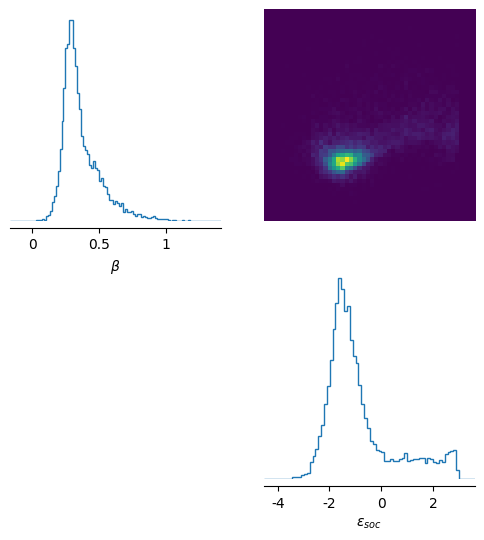

In [162]:
from sbi.analysis import pairplot
_ = pairplot(posterior_sample, # .exp(),
             # limits=[[0, 2], [0, 10]],
             figsize=(6, 6),
             labels=[r"$\beta$", r"$\epsilon_{soc}$"],
             )

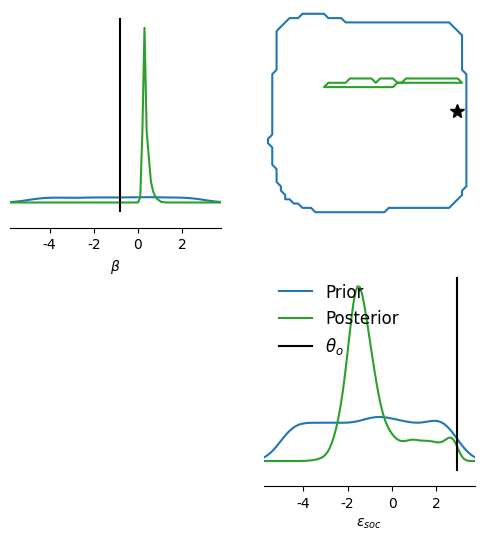

In [161]:
import matplotlib.pyplot as plt
fig, ax = pairplot(
    [
        prior.sample((1000,)), # .exp(),
        posterior_sample, # .exp(),
    ],
    points=np.log([fitted_params.loc[['beta', 'eps_soc'], 'value']]),
    diag="kde",
    upper="contour",
    diag_kwargs=dict(bins=100),
    upper_kwargs=dict(levels=[0.95]),
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["k"],
    ),
    labels=[r"$\beta$", r"$\epsilon_{soc}$"],
    figsize=(6, 6),
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "Posterior", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
)

In [164]:
posterior_sample[:, 1].exp().mean()

tensor(1.4927)